<a href="https://colab.research.google.com/github/ozgurshn/Colab-notebooks/blob/master/pretrained_imagenet_classifier_fastai_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretrained ImageNet Classifier with fastai v1

- Author: [Ozgur Sahin](https://github.com/ozgurshn)

- Source: https://github.com/piegu/fastai-projects/blob/master/pretrained-imagenet-classifier-fastai-v1.ipynb
- Ref: [Fastai v1](https://docs.fast.ai/index.html) (Deep Learning library on PyTorch)

## Objective

The objective is to use [fastai v1](https://docs.fast.ai/index.html) instead of Pytorch code in order to classify images into 1000 classes by using an ImageNet winner model.

## Initialisation

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.widgets import *

In [0]:
from io import BytesIO

In [0]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.60
cuda: False


In [0]:
path = Config.data_path()
os.makedirs(path/'imagenet', exist_ok=True)
path = path/'imagenet'

## Get the ImageNet classes

**Option 1**: download json file from https://discuss.pytorch.org/t/imagenet-classes/4923/3

In [0]:
import urllib.request, json

# Distant json file
url_json = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
with urllib.request.urlopen(url_json) as url:
    json_file = json.loads(url.read().decode())
    
#json.load(open())
# local json file 
#json_file = json.load(open(path/'imagenet_class_index.json'))

classes = [json_file[str(k)][1] for k in range(len(json_file))]

**Option 2**: download txt file from the [Kaggle ImageNet Object Localization Challenge](https://www.kaggle.com/c/imagenet-object-localization-challenge/data)

In [0]:
path = Config().data_path()

In [0]:
classes[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Model

Let's use resnet50.

In [0]:
# Get weights of the model and add nn.LogSoftmax(dim=1) to the end
model_name = 'resnet50'
model = models.resnet50(pretrained=True)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))

In [0]:
# Transformation to apply to image before prediction (center crop)
# tfms = get_transforms() is possible too
tfms = [ [], [crop_pad()] ]

In [0]:
# Get an empty databunch with the ImageNet classes
# WARNING single_from_classes is deprecated (https://docs.fast.ai/vision.data.html#ImageDataBunch.single_from_classes)
data = ImageDataBunch.single_from_classes(path, classes, ds_tfms=tfms, size=224).normalize(imagenet_stats)

In [0]:
# Get the learner of the model
learn = Learner(data, model)

In [0]:
# Save the learner
learn.export(f'{model_name}.pkl')

## Data to classify

In [0]:
# List of images to classify
images = [
          ('cat', 'https://www.readersdigest.ca/wp-content/uploads/sites/14/2011/01/4-ways-cheer-up-depressed-cat.jpg'),
          ('dog', 'https://c.photoshelter.com/img-get/I0000q_DdkyvP6Xo/s/900/900/Pomeranian-Dog-with-Ball.jpg'),
          ('wine', 'https://www.thetimes.co.uk/imageserver/image/methode%2Fsundaytimes%2Fprod%2Fweb%2Fbin%2F5e7dc0d2-9b24-11e8-9837-8c5d4fba4ce3.jpg?crop=2667%2C1500%2C0%2C0&resize=685')
         ]

## Get the 3 best predictions

In [0]:
model_name = 'resnet50'

In [0]:
# Import the learner object
# Tutorial online at https://docs.fast.ai/tutorial.inference.html
learn = load_learner(path, f'{model_name}.pkl')

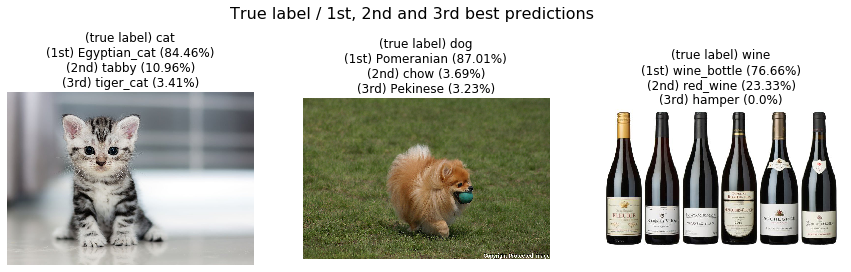

In [0]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('True label / 1st, 2nd and 3rd best predictions', fontsize=16)

for i, image in enumerate(images):
    
    # Get image
    class_name, img_url = image[0], image[1]
    response = requests.get(img_url)
    img = open_image(BytesIO(response.content))

    # Get best first prediction
    pred_1_class, indice, preds = learn.predict(img)

    # Get all best predictions
    preds_sorted, idxs = preds.sort(descending=True)
    
    # Get best 3 predictions - classes
    pred_2_class = learn.data.classes[idxs[1]]
    pred_3_class = learn.data.classes[idxs[2]]
    
    # Get best 3 predictions - probabilities
    pred_1_prob = np.round(100*preds_sorted[0].item(),2)
    pred_2_prob = np.round(100*preds_sorted[1].item(),2)
    pred_3_prob = np.round(100*preds_sorted[2].item(),2)
    preds_best3 = [f'{pred_1_class} ({pred_1_prob}%)', f'{pred_2_class} ({pred_2_prob}%)', f'{pred_3_class} ({pred_3_prob}%)']
    
    # Display images with True label / 1st, 2nd and 3rd best Predictions
    img.show(ax=ax[i],
             title=f'(true label) {class_name}\n(1st) {preds_best3[0]}\n(2nd) {preds_best3[1]}\n(3rd) {preds_best3[2]}')